# Imports

In [1]:
!pip install scikit-image

In [2]:
import numpy as np
import os
import json
import cv2
from skimage.feature import graycomatrix, graycoprops
#from skimage.feature import greycomatrix, greycoprops
from skimage import data, exposure
import matplotlib.pyplot as plt
import warnings
from utils import *

In [3]:
warnings.filterwarnings("ignore")

# Helper Functions

In [4]:
# define a function that determines the mean and standard deviation of each RGB and and L*a*b*
# color-space channel for an image
def compute_channel_stats(image_path):
    # read the image
    img = cv2.imread(image_path)
    
    # convert image to L*a*b* color space
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # compute mean and standard deviation for each color channel (RGB and L*a*b*)
    mean_rgb, std_rgb = cv2.meanStdDev(img)
    mean_lab, std_lab = cv2.meanStdDev(lab_img)
    
    # flatten the results into a feature vector
    channel_stats = np.concatenate((mean_rgb.flatten(), std_rgb.flatten(), mean_lab.flatten(), std_lab.flatten()))
    
    return channel_stats

In [10]:
def compute_glcms(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    
    # distance between pixels
    distances = [1]  
    # angles for texture computation
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] 
    glcm = graycomatrix(img, distances, angles, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast').ravel().mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').ravel().mean()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel().mean()
    energy = graycoprops(glcm, 'energy').ravel().mean()
    correlation = graycoprops(glcm, 'correlation').ravel().mean()
    
    return [contrast, dissimilarity, homogeneity, energy, correlation]

In [11]:
# define a function that loops through each file to generate a dictionary that contains
# the feature vectors of all images in each class
def generate_feature_vectors(files, directory):
    feature_vectors = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img_path = os.path.join(directory, class_name, file_name)
        
        # compute color statistics
        channel_stats = compute_channel_stats(img_path)
        
        # compute GLCM texture features
        glcm_features = compute_glcms(img_path)
    
        combined_features = np.concatenate((channel_stats, glcm_features))
        
        # append each channel_stats array to the correct class in feature_vectors
        if class_name not in feature_vectors:
            feature_vectors[class_name] = []
        feature_vectors[class_name].append(channel_stats)
    
    return feature_vectors

# Import data

In [12]:
# define file directory
directory = '../data/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

train/validation/test subsets were loaded from a pre-generated file
	Number of train files: 4799
	Number of val files: 1599
	Number of test files: 1601


# Generate Feature Vectors

In [13]:
# generate the set of feature vectors for all images in each class
glcm_features = generate_feature_vectors(train_files, directory)

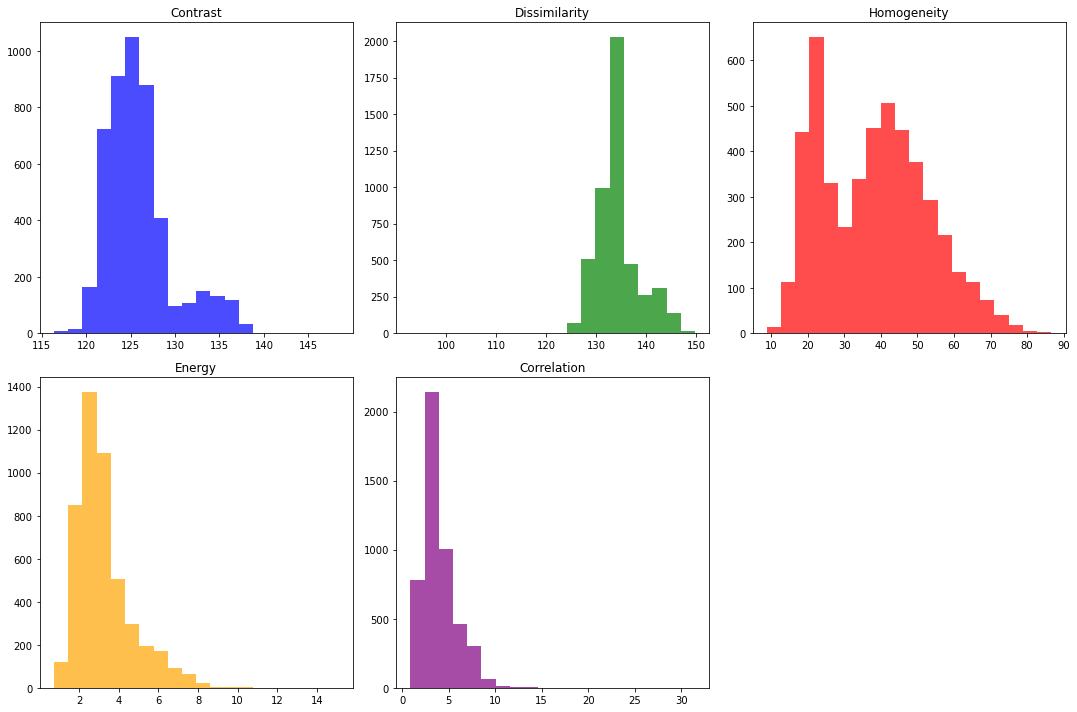

In [25]:
# extract GLCM features for visualization
contrast_values = []
dissimilarity_values = []
homogeneity_values = []
energy_values = []
correlation_values = []

for class_name, feature_vectors in glcm_features.items():
    for feature_vector in feature_vectors:
        contrast_values.append(feature_vector[-5]) 
        dissimilarity_values.append(feature_vector[-4]) 
        homogeneity_values.append(feature_vector[-3]) 
        energy_values.append(feature_vector[-2])  
        correlation_values.append(feature_vector[-1])  

# plot histograms for each GLCM feature
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].hist(contrast_values, bins=20, color='blue', alpha=0.7)
axes[0, 0].set_title('Contrast')
axes[0, 1].hist(dissimilarity_values, bins=20, color='green', alpha=0.7)
axes[0, 1].set_title('Dissimilarity')
axes[0, 2].hist(homogeneity_values, bins=20, color='red', alpha=0.7)
axes[0, 2].set_title('Homogeneity')
axes[1, 0].hist(energy_values, bins=20, color='orange', alpha=0.7)
axes[1, 0].set_title('Energy')
axes[1, 1].hist(correlation_values, bins=20, color='purple', alpha=0.7)
axes[1, 1].set_title('Correlation')

# hide the empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [26]:
# inspections
print(type(glcm_features))
print(glcm_features.keys())
print(type(glcm_features['beach']))
print(len(glcm_features['beach']))
print(glcm_features['beach'][0])

<class 'dict'>
dict_keys(['parking_space', 'beach', 'forest', 'overpass', 'river', 'dense_residential', 'swimming_pool', 'chaparral', 'freeway', 'harbor'])
<class 'list'>
479
[113.95576477 127.46353149 119.84751892  22.51988622  21.80362058
  22.92205582 133.3782196  122.48179626 134.45556641  21.85814155
   1.91485269   1.31443199]
